In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
import pandas as pd

from scipy.optimize import curve_fit


## A simple test to see how to extract the correct data sets. 

We need one additional thing: ask Lena about the time evolutions for more of the runs (for these, I don't think I have the Q_cmb evolution...)

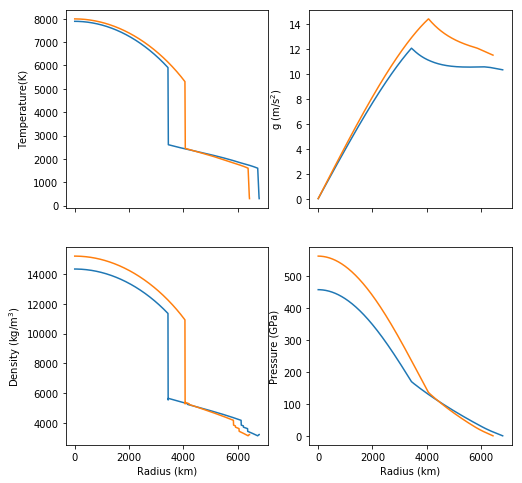

In [2]:
files = ['data_prof_M_ 1.2_Fe_30.0000_FeM_ 0.0000.res',
         'data_prof_M_ 1.2_Fe_50.0000_FeM_ 0.0000.res']

names = ["g(m/s^2)", "p(GPa)", "rho(kg/m^3)","r(m)", "T(K)", "oups", "Cp(J/kgK)", "alpha(10^-5 1/s)", "Gruneisen(1)", \
             "KT(GPa)", "KS(GPa)", "G(GPa)", "ElCond (Siemens)", "Material-Parameter" ]

fig, ax3 = plt.subplots(2,2, figsize=[8,8], sharex=True)


def figure(data, i, symb="-"): 
    ax3[0,0].plot(data["r(m)"]/1e3, data["T(K)"], symb)
    ax3[0,1].plot(data["r(m)"]/1e3, data["g(m/s^2)"], symb)
    ax3[1,0].plot(data["r(m)"]/1e3, data["rho(kg/m^3)"], symb)
    ax3[1,1].plot(data["r(m)"]/1e3, data["p(GPa)"], symb)
    ax3[0,0].set_ylabel("Temperature(K)")
    ax3[0,1].set_ylabel("g (m/s$^2$)")
    ax3[1,0].set_ylabel("Density (kg/m$^3$)")
    ax3[1,1].set_ylabel("Pressure (GPa)")
    ax3[1,0].set_xlabel("Radius (km)")
    ax3[1,1].set_xlabel("Radius (km)")
    
for i, (filename) in enumerate((files)):
    data = pd.read_csv(filename, skipinitialspace=True, sep=" ", names=names, index_col=False)
    figure(data, i)

## Focus on the core values only

[1.43254913e+04 7.85503120e+06 4.38821508e-01]
457.0129233
1770.0242456690437
[1.51882396e+04 8.12865084e+06 4.85704110e-01]
561.927049
2130.669826279427


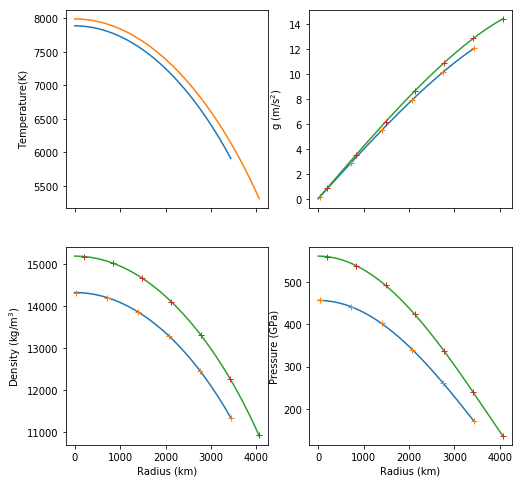

In [3]:
files = ['data_prof_M_ 1.2_Fe_30.0000_FeM_ 0.0000.res',
         'data_prof_M_ 1.2_Fe_50.0000_FeM_ 0.0000.res']

fig, ax3 = plt.subplots(2,2, figsize=[8,8], sharex=True)

def theoritical_density(r, *args):
    """ Equation (5) in Labrosse 2015 """
    rho_0, L_rho, A_rho = args
    return rho_0*(1-r**2/L_rho**2-A_rho*r**4/L_rho**4)

def gravity(r, *args):
    G = 6.67430e-11
    rho_0, L_rho, A_rho = args
    parenthesis = 1-3/5*r**2/L_rho**2-3/7*A_rho*r**4/L_rho**4
    return 4.*np.pi/3.*G*rho_0*r*parenthesis

def pressure_diff(r, *args):  #in GPa
    rho_0, L_rho, A_rho = args
    G = 6.67430e-11
    K0 = L_rho**2/3.*2.*np.pi*G*rho_0**2 /1e9 #in GPa
    print(K0)
    parenthesis = r**2/L_rho**2-4./5.*r**4/L_rho**4
    return -K0*parenthesis



initial_guess = 12500, 8000e3, 0.484 # initial guess, obtained from Earth values. 

for i, (filename) in enumerate((files)):
    profiles = pd.read_csv(filename, skipinitialspace=True, sep=" ", names=names, index_col=False)
    core = profiles[profiles["Material-Parameter"]==8.]
    rho = core["rho(kg/m^3)"]
    radius = core["r(m)"]
    figure(core, i)
    
    popt, pcov = curve_fit(theoritical_density, radius, rho, initial_guess)
    print(popt)
    
    ax3[1,0].plot(radius[::100]/1e3, theoritical_density(radius[::100], *popt), '+')
    ax3[0,1].plot(radius[::100]/1e3, gravity(radius[::100], *popt), '+')
    P0 = core["p(GPa)"].iloc[-1]
    print(P0)
    ax3[1,1].plot(radius[::100]/1e3, pressure_diff(radius[::100], *popt)+P0, '+')


In [4]:
print(core)

      g(m/s^2)      p(GPa)   rho(kg/m^3)          r(m)         T(K)  \
369  14.435245  135.820358  10919.533088  4.060163e+06  5308.915306   
370  14.422036  136.836133  10935.191218  4.053724e+06  5318.719775   
371  14.408773  137.852435  10950.870432  4.047284e+06  5328.494618   
372  14.395456  138.869252  10966.472542  4.040844e+06  5338.239959   
373  14.382085  139.886573  10981.997088  4.034405e+06  5347.956028   
374  14.368661  140.904385  10997.492878  4.027965e+06  5357.642999   
375  14.355184  141.922680  11012.959692  4.021526e+06  5367.300993   
376  14.341655  142.941446  11028.347882  4.015086e+06  5376.930183   
377  14.328072  143.960672  11043.706503  4.008646e+06  5386.530742   
378  14.314437  144.980348  11059.035336  4.002207e+06  5396.102788   
379  14.300749  146.000462  11074.284497  3.995767e+06  5405.646493   
380  14.287009  147.021005  11089.503283  3.989328e+06  5415.162026   
381  14.273217  148.041965  11104.691480  3.982888e+06  5424.649504   
382  1

In [42]:
import yaml


MEarth = 5.972e24 #kge
R_Earth = 6371 #km
G = 6.67384e-11 #m3/kg/s2

def open_data_profiles(filename, core=False): 
    names = ["g(m/s^2)", "p(GPa)", "rho(kg/m^3)","r(m)", "T(K)", "oups", "Cp(J/kgK)", "alpha(10^-5 1/s)", "Gruneisen(1)", \
             "KT(GPa)", "KS(GPa)", "G(GPa)", "ElCond (Siemens)", "Material-Parameter" ]
    data = pd.read_csv(filename, skipinitialspace=True, sep=" ", 
                       names=names, index_col=False)
    if core == True:
        data = data[data["Material-Parameter"]==8.]
    return data

def density_Labrosse2015(r, *args):
    """ Equation (5) in Labrosse 2015 """
    rho_0, L_rho, A_rho = args
    return rho_0*(1-r**2/L_rho**2-A_rho*r**4/L_rho**4)

def find_Lrho_Arho(profile):
    """ least square to fit the function density to the data.count
    
    curve_fit use non-linear least square,
    the default method is Levenberg-Marquardt algorithm as implemented in MINPACK.
    (doesn't handle bounds and sparse jacobians. Should be enough here)
     """
    rho = profile["rho(kg/m^3)"]
    radius = profile["r(m)"]
    initial_guess = 12500, 8000e3, 0.484 # initial values from Labrosse 2015 (for the Earth)
    popt, pcov = curve_fit(density_Labrosse2015, radius, rho, initial_guess)
    rho_0, L_rho, A_rho = popt
    return rho_0.tolist(), L_rho.tolist(), A_rho.tolist()


def name_file(XFe, Mp, FeM): 
    return "data_prof_M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.res".format(Mp, XFe, FeM)

def Earth():   
        """ Default values for Earth (see Labrosse 2015) """
        param = {  
                    "r_OC" : 3480.e3,          # Core radius (m)
                    "r_IC" : 1221.e3,          # Present inner core radius (m)
                    "r_IC_0": 0., # Initial inner core radius (m)
                    #
                    "alpha_c" : 1.3e-5,           # Thermal expansion coefficient at center (K-1)
                    "CP" : 750.,             # Specific heat (J.kg-1.K-1)
                    "gamma" : 1.5,              # Grueneisen parameter
                    # Parameters obtained from the fitting of the density
                    "rho_0" :  12502.,           # Density at center (kgm-3)
                    "L_rho" : 8039e3,             # (m)
                    "A_rho" : 0.484,              # (no unit)
                    # Parameter obtained from the qs_**.res  
                    "Q_CMB" : 7.4e12,           # Present CMB flux (W)
                    # Parameters not expected to be modified
                    "Deltarho_ICB" : 500.,             # Density jump at ICB (kgm-3)
                    "DeltaS" : 127.,             # Entropy of crystallization (Jkg-1K-1)
                    "H" : 0.,               # Radioactivity
                    "k_c" : 163.,             # Thermal conductivity at center (Wm-1K-1)
                    "beta" : 0.83,           # coefficient of compositional expansion
                    "chi0" : 0.056,            # Difference in mass fraction of light elements across ICB
                    # Phase diag (maybe not modified?)
                    "dTL_dchi" : -21.e3,           # Compositional dependence of liquidus temperature (K)
                    "dTL_dP" : 9.e-9,            # Pressure dependence of liquidus temperature (Pa-1)
                    "TL0" : 5700.,            # Melting temperature at center (K)
        }
        return param

def average_volume(profile, name_variable):
    
    profile["dV"] = 4*np.pi*profile["r(m)"]
    volume = profile["dV"].sum()
    quantity = profile["dV"]*profile[name_variable]
    quantity_total = quantity.sum()
    
    return quantity_total/volume

    
def write_parameter_file(XFe, Mp, FeM):
    
    filename = name_file(XFe, Mp, FeM)
    core = open_data_profiles(filename, core=True)
    
    param = Earth()
    
    param["rho_0"], param["L_rho"], param["A_rho"] = find_Lrho_Arho(core)
    #print(rho_0, L_rho/1e3, A_rho)
    
    param["r_OC"] = core["r(m)"].iloc[-1].tolist()
    
    param["CP"] = average_volume(core, "Cp(J/kgK)").tolist()
    param["alpha_c"] = average_volume(core, "alpha(10^-5 1/s)").tolist() * 1e-5
    param["gamma"] = average_volume(core, "Gruneisen(1)").tolist()
    
    output_filename = "M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM)
    
    with open(output_filename, 'w') as outfile:
        yaml.dump(param, outfile, default_flow_style=False)
    

    
write_parameter_file(30, 1.2, 0)